# Customer Insights

*Work in Progress*

This notebook aims to provide a brief demonstration of how this codebase could be used for gaining customer insights.

In [1]:
"""load dependencies and define constants"""
import os
import sys
import requests
import numpy as np
import pandas as pd
from decimal import Decimal
from web3 import Web3
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

sys.path.append("..")
from src.utils.network import client, parse_json
from yearn_data.yearn import Yearn
from yearn_data.utils.web3 import fetch_events, get_contract
from yearn_data.utils.price import get_usdc_price

# constants
ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'
FROM_BLOCK = 13900000  # Dec-29-2021
BATCH_SIZE = 500000
API_ENDPOINT = "https://api.etherscan.io/api"

In [2]:
"""get current block and load vaults from the yearn instance"""
load_dotenv()
w3 = Web3(Web3.HTTPProvider(os.environ['WEB3_PROVIDER']))
current_block = w3.eth.get_block("latest")["number"]
print(f"current block number: {current_block}")

yearn = Yearn()
vaults = yearn.vaults
print(f"loaded metadata for {len(vaults)} vaults (v2)")

current block number: 14682538
loaded metadata for 92 vaults (v2)


In [3]:
"""get addresses that withdrew from vaults"""
def get_withdrawals(data, vault, from_block, to_block):
    events = fetch_events(vault.address, "Transfer", from_block, to_block)
    withdraws = [event for event in events if event['args']['receiver'] == ZERO_ADDRESS]  # burn vault tokens
    for withdraw in withdraws:
        account = withdraw['args']['sender']
        shares = Decimal(withdraw['args']['value'] / 10**vault.token.decimals)
        usdc_amount = shares * share_price
        if account in data:
            data[account] += usdc_amount
        else:
            data[account] = usdc_amount

data = {}
for vault in tqdm(vaults):
    # approximate the share price by the current usdc value, skip if not available
    try:
        share_price = get_usdc_price(vault.token.address)
    except:
        continue

    from_block = FROM_BLOCK
    to_block = from_block + BATCH_SIZE
    while to_block < current_block:
        get_withdrawals(data, vault, from_block, to_block)
        from_block += BATCH_SIZE
        to_block = from_block + BATCH_SIZE
    get_withdrawals(data, vault, from_block, "latest")

df = pd.DataFrame(data.items(), columns=["address", "approx. USDC value"])
df['approx. USDC value'] = pd.to_numeric(df['approx. USDC value'])
df.set_index(keys=['address'], inplace=True)
df.sort_values('approx. USDC value', inplace=True, ascending=False)
print(df.head(10))

  0%|          | 0/92 [00:00<?, ?it/s]

                                            approx. USDC value
address                                                       
0xd6b88257e91e4E4D4E990B3A858c849EF2DFdE8c        4.320239e+08
0x6d75657771256C7a8CB4d475fDf5047B70160132        2.119898e+08
0x6Fe02BE0EC79dCF582cBDB936D7037d2eB17F661        2.056419e+08
0xb039eA6153c827e59b620bDCd974F7bbFe68214A        1.275850e+08
0xb698f815918e0A11cf802184f36f02cD4602EBD4        5.857186e+07
0x546E6711032Ec744A7708D4b7b283A210a85B3BC        5.195486e+07
0xE8E8f41Ed29E46f34E206D7D2a7D6f735A3FF2CB        1.699023e+07
0x4b92d19c11435614CD49Af1b589001b7c08cD4D5        1.506286e+07
0x3a8C4eaB850D2265Cb0d6bBB442Ae08a4dd380c9        1.334229e+07
0xbC27C4873D0ddE214387cE5a838DC78857633Ea2        1.323721e+07


<AxesSubplot:xlabel='address', ylabel='USDC log-value'>

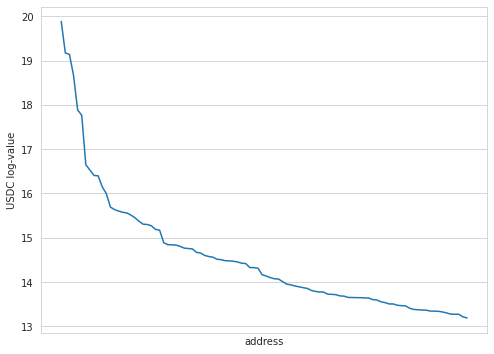

In [4]:
"""the log-value distribution of the top 100 addresses"""
sns.set_style('whitegrid')
_, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks([])
ax.set_ylabel("USDC log-value")
np.log(df['approx. USDC value'].iloc[:100]).plot(ax=ax)

In [5]:
"""get the caller of the contracts for the top 100 addresses"""
def get_callers(data, contract, from_block, to_block):
    for event in contract.events:
        events = fetch_events(contract.address, event.event_name, from_block, to_block)
        for event in events:
            for v in event['args'].__dict__.values():
                for vault in vaults:
                    if v == vault.address:
                        data.append(event.args.sender)
                        break

data = []
for idx, address in enumerate(tqdm(df.index[:100])):
    # try to fetch the contract abi, skip if not available
    try:
        contract = get_contract(address)

        from_block = FROM_BLOCK
        to_block = from_block + BATCH_SIZE
        while to_block < current_block:
            get_callers(data, contract, from_block, to_block)
            from_block += BATCH_SIZE
            to_block = from_block + BATCH_SIZE
        get_callers(data, contract, from_block, "latest")

    except:
        data.append(address)
print(f"Fetched {len(data)} addresses from chain")

  0%|          | 0/100 [00:00<?, ?it/s]

Fetched 1509 addresses from chain


In [6]:
"""get the transaction receivers from etherscan and sort by count"""
params = {
    'module': 'account',
    'action': 'txlist',
    'startblock': FROM_BLOCK,
    'endblock': 99999999,
    'apiKey': os.environ['ETHERSCAN_TOKEN']
}
addresses = []
for caller in tqdm(data):
    params['address'] = caller
    response = client('get', API_ENDPOINT, params=params)
    jsoned = parse_json(response)
    if jsoned is None:
        continue

    txns = jsoned['result']
    for tx in txns:
        if tx['from'] == caller.lower():
            addresses.append(tx['to'])

addresses, counts = np.unique(addresses, return_counts=True)
df = pd.DataFrame(np.asarray([addresses, counts]).T, columns=['address', 'counts'])
df.counts = pd.to_numeric(df.counts)
df.sort_values('counts', inplace=True, ascending=False)
df.index = np.arange(len(addresses))
print(df.head(10))

  0%|          | 0/1509 [00:00<?, ?it/s]

                                      address  counts
0  0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45    5948
1  0x1111111254fb6c44bac0bed2854e76f90643097d    5529
2  0xdef1c0ded9bec7f1a1670819833240f027b25eff    4962
3  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48    4583
4  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2    4528
5  0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f    4434
6  0x7f268357a8c2552623316e2562d90e642bb538e5    3831
7  0x7be8076f4ea4a4ad08075c2508e481d6c946d12b    3810
8  0xd6b88257e91e4e4d4e990b3a858c849ef2dfde8c    2909
9  0x920d9bd936da4eafb5e25c6bdc9f6cb528953f9f    1920
